In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from classes import LogisticRegression
from methods import normalize, gen_cluster

np.random.seed(13)

### Логистическая регрессия

Вычисление предсказания логистической регрессией для объекта $x_i \in \mathbb{R}^n$ :

* $f = w^T x_i + b, \quad w \in \mathbb{R}^n, b \in \mathbb{R}$
* $a = \sigma (f)$

Сигмоида:

$$\sigma(x) = \frac{1}{1 + e^{-x}}$$

![alt text](https://upload.wikimedia.org/wikipedia/commons/a/ac/Logistic-curve.png)

Логистическая фунция потерь:

$$L_i(a) = -y_i \cdot log(a) - (1 - y_i) \cdot log(1 - a)$$

Производные функции по параметрам:

$$\frac{\partial L}{\partial w} = \frac{1}{m}\sum_{i=1}^{m} \frac{\partial L_i}{\partial w}$$

$$\frac{\partial L_i}{\partial w} = \frac{\partial L_i}{\partial a} \cdot \frac{\partial a}{\partial z} 
\cdot \frac{\partial z}{\partial w} = \frac {a - y_i} {a \cdot (1-a)} \cdot a \cdot (1-a) \cdot x_i = (a-y_i) \cdot x_i $$

$$\frac{\partial L}{\partial b} = \frac{1}{m}\sum_{i=1}^{m} \frac{\partial L_i}{\partial b}$$

$$\frac{\partial L_i}{\partial b} = \frac{\partial L_i}{\partial a} \cdot \frac{\partial a}{\partial z} 
\cdot \frac{\partial z}{\partial b} = \frac {a - y_i} {a \cdot (1-a)} \cdot a \cdot (1-a) \cdot 1 = a-y_i $$

Используются для минимизации функции потерь $L$ с помощью градиентного спуска:

$$w_{j+1} = w_j - \alpha \cdot \nabla \frac{\partial L}{\partial w}(w_j, b_j)$$

$$b_{j+1} = b_j - \alpha \cdot \nabla \frac{\partial L}{\partial b}(w_j, b_j)$$

### Данные

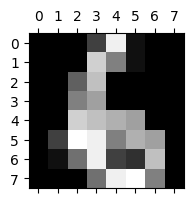

6


In [2]:
data = load_digits()

X = data["data"]
# В качестве целевой переменной индикатор того, больше число 5 или нет. Таким образом, сводим задачу к бинарной классификации.
y = (data["target"] >= 5).astype(np.int32)

plt.figure(figsize=(2, 2))
plt.gray()
index = np.random.randint(0, len(X) - 1)
plt.matshow(X[index].reshape(8, 8), fignum=1)
plt.show()
print(data.target[index])

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.66, shuffle=True)
X_train.shape, X_test.shape

((1186, 64), (611, 64))

### Используя цикл

In [4]:
epochs = 500
rep_int = int(epochs / 20)

In [5]:
%%time
model = LogisticRegression(epochs=epochs, report_interval=rep_int)
model.fit(X_train, y_train, eval_set=(X_test, y_test))

CPU times: total: 7.67 s
Wall time: 8.09 s


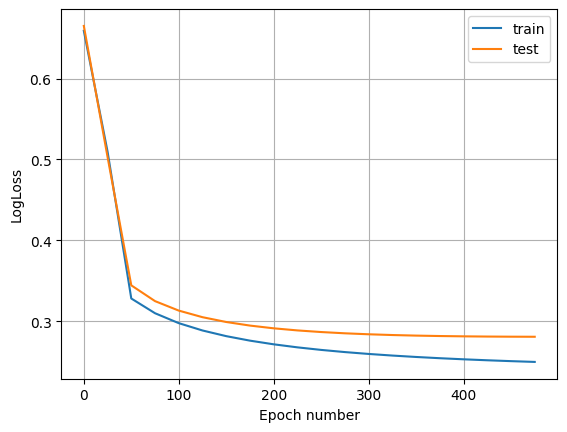

In [6]:
epoch_numbers = np.arange(0, len(model.losses_train)) * model.report_interval

plt.plot(epoch_numbers, model.losses_train, label="train")
plt.plot(epoch_numbers, model.losses_test, label="test")
plt.xlabel("Epoch number")
plt.ylabel("LogLoss")
plt.legend()
plt.grid(True)

In [7]:
test_prediction = model.predict(X_test)
test_accuracy = np.sum((test_prediction > 0.5) == y_test) / len(test_prediction)
print(f"Test accuracy: {round(test_accuracy, 3)}")

Test accuracy: 0.9


In [8]:
train_prediction = model.predict(X_train)
train_accuracy = np.sum((train_prediction > 0.5) == y_train) / len(train_prediction)
print(f"Train accuracy: {round(train_accuracy, 3)}")

Train accuracy: 0.909


### Используя векторизацию

In [9]:
%%time
model = LogisticRegression(epochs=epochs, report_interval=rep_int)
model.fit_vec(X_train, y_train, eval_set=(X_test, y_test))

CPU times: total: 578 ms
Wall time: 624 ms


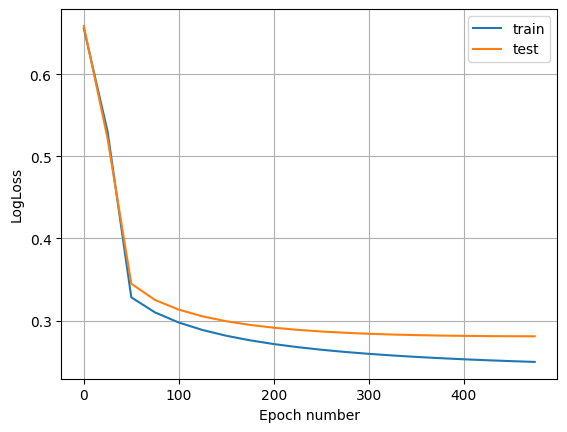

In [10]:
epoch_numbers = np.arange(0, len(model.losses_train)) * model.report_interval

plt.plot(epoch_numbers, model.losses_train, label="train")
plt.plot(epoch_numbers, model.losses_test, label="test")
plt.xlabel("Epoch number")
plt.ylabel("LogLoss")
plt.legend()
plt.grid(True)

In [11]:
test_prediction = model.predict(X_test)
test_accuracy = np.sum((test_prediction > 0.5) == y_test) / len(test_prediction)
print(f"Test accuracy: {round(test_accuracy, 3)}")

Test accuracy: 0.9


In [12]:
train_prediction = model.predict(X_train)
train_accuracy = np.sum((train_prediction > 0.5) == y_train) / len(train_prediction)
print(f"Train accuracy: {round(train_accuracy, 3)}")

Train accuracy: 0.908


### Модель с двумя признаками

In [13]:
epochs = 1000
rep_int = int(epochs / 20)
l_rate = 0.05

num_dots = 100  # число точек в каждом кластере
num_anom = int(0.05 * num_dots)  # число аномальных точек
radius = 5
center_1 = (10, 5)
center_2 = (0, 0)

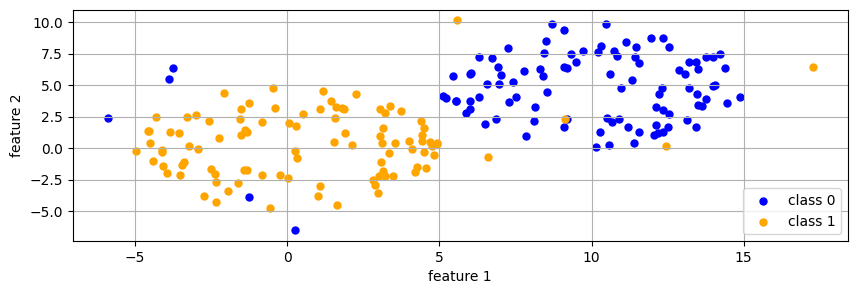

In [14]:
# Первоначальные кластеры.
cluster_1 = gen_cluster(num_dots - num_anom, radius, center_1)
cluster_2 = gen_cluster(num_dots - num_anom, radius, center_2)

# Аномальные точки.
anom_1 = gen_cluster(num_anom, 1.5 * radius, center_2)
anom_2 = gen_cluster(num_anom, 1.5 * radius, center_1)

# Объединение кластеров с аномальными точками.
cluster_1 = np.insert(cluster_1, 0, anom_1.T, axis=1)
cluster_2 = np.insert(cluster_2, 0, anom_2.T, axis=1)

# Признаки.
feature_1 = np.concatenate((cluster_1[0], cluster_2[0]))
feature_2 = np.concatenate((cluster_1[1], cluster_2[1]))

# Целевая переменная.
y = np.concatenate((np.zeros(num_dots), np.ones(num_dots)))

plt.figure(figsize=(10, 3))
plt.scatter(*cluster_1, linewidths=0.01, color="blue")
plt.scatter(*cluster_2, linewidths=0.01, color="orange")
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.legend(["class 0", "class 1"], loc ="lower right")
plt.grid(True)
plt.show()

In [15]:
X = np.column_stack((feature_1, feature_2, y))  # соединяем в колонки
np.random.shuffle(X)  # перемешиваем строки
y = X[:, -1]  # сохраняем целевую переменную
X = np.delete(X, obj=-1, axis=1)  # удаляем целевую переменную

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.66, shuffle=True)
X_train.shape, X_test.shape

((132, 2), (68, 2))

In [16]:
%%time
model = LogisticRegression(learning_rate=l_rate, epochs=epochs, report_interval=rep_int)
model.fit_vec(X_train, y_train, eval_set=(X_test, y_test))

CPU times: total: 109 ms
Wall time: 132 ms


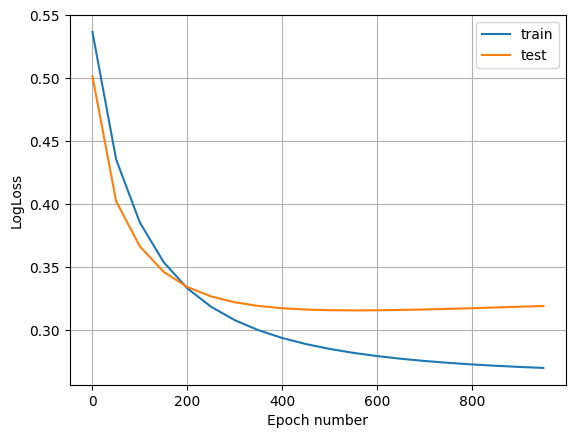

In [17]:
epoch_numbers = np.arange(0, len(model.losses_train)) * model.report_interval

plt.plot(epoch_numbers, model.losses_train, label="train")
plt.plot(epoch_numbers, model.losses_test, label="test")
plt.xlabel("Epoch number")
plt.ylabel("LogLoss")
plt.legend()
plt.grid(True)

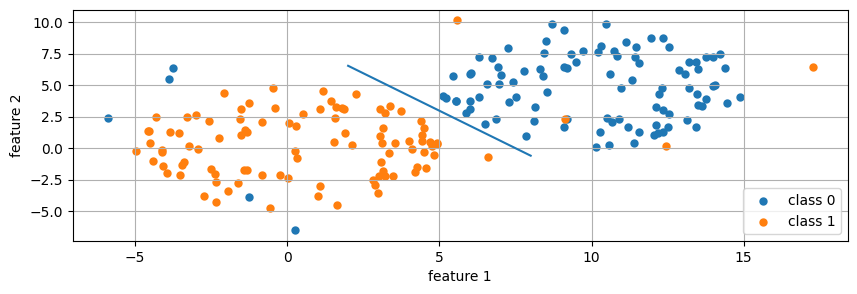

In [18]:
# Разделяющая линия.
div_line_x = np.linspace(2, 8, num_dots)
div_line_y = -(model.weights[0] * div_line_x + model.bias) / model.weights[1]  # рещение уравнения w1 * x + w2 * y + bias = 0

plt.figure(figsize=(10, 3))
plt.scatter(*cluster_1, linewidths=0.01)
plt.scatter(*cluster_2, linewidths=0.01)
plt.plot(div_line_x, div_line_y)
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.legend(["class 0", "class 1"], loc="lower right")
plt.grid(True)
plt.show()

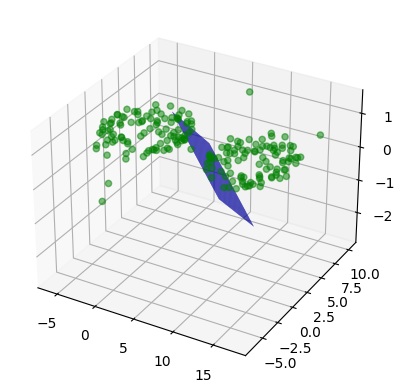

In [19]:
# Разделяющая поверхность.
u = np.linspace(2, 8, num_dots)
div_surf_x, div_surf_y = np.meshgrid(u, u)
div_surf_z = model.weights[0] * div_surf_x + model.weights[1] * div_surf_y + model.bias  # w1 * x + w2 * y + bias = z

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(X.transpose()[0], X.transpose()[1], y, color="green", alpha=0.5)
ax.plot_surface(div_surf_x, div_surf_y, div_surf_z, alpha=1, color="blue")

In [20]:
test_prediction = model.predict(X_test)
test_accuracy = np.sum((test_prediction > 0.5) == y_test) / len(test_prediction)
print(f"Test accuracy: {round(test_accuracy, 3)}")

Test accuracy: 0.941


In [21]:
train_prediction = model.predict(X_train)
train_accuracy = np.sum((train_prediction > 0.5) == y_train) / len(train_prediction)
print(f"Train accuracy: {round(train_accuracy, 3)}")

Train accuracy: 0.962


### Добавим L2 регуляризацию и степени для feature_1

In [22]:
degree = 5

# Будем аппроксимировать feature_1 многочленом.
feature_1_train = X_train[:, 0]
feature_1_test = X_test[:, 0]
feature_1_train_deg = np.array([feature_1_train ** deg for deg in range(1, degree + 1)]).transpose()
feature_1_test_deg = np.array([feature_1_test ** deg for deg in range(1, degree + 1)]).transpose()

feature_1_train_deg.shape, feature_1_test_deg.shape

((132, 5), (68, 5))

In [23]:
# Соединим все степени feature_1 и feature_2.
X_train_deg = np.insert(feature_1_train_deg, feature_1_train_deg.shape[1], X_train[:, -1], axis=1)
X_test_deg = np.insert(feature_1_test_deg, feature_1_test_deg.shape[1], X_test[:, -1], axis=1)

# Нормализация.
X_train_deg = normalize(X_train_deg)
X_test_deg = normalize(X_test_deg)

X_train_deg.shape, X_test_deg.shape

((132, 6), (68, 6))

In [24]:
%%time
model = LogisticRegression(learning_rate=l_rate, reg_type="l2", reg_coeff=0.1, epochs=epochs, report_interval=rep_int)
model.fit_vec(X_train_deg, y_train, eval_set=(X_test_deg, y_test))

CPU times: total: 109 ms
Wall time: 137 ms


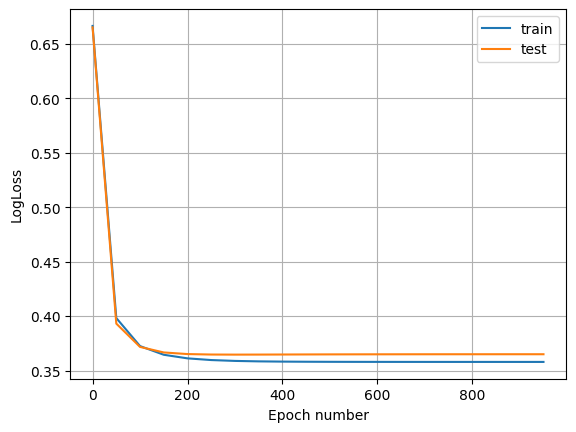

In [25]:
epoch_numbers = np.arange(0, len(model.losses_train)) * model.report_interval

plt.plot(epoch_numbers, model.losses_train, label="train")
plt.plot(epoch_numbers, model.losses_test, label="test")
plt.xlabel("Epoch number")
plt.ylabel("LogLoss")
plt.legend()
plt.grid(True)

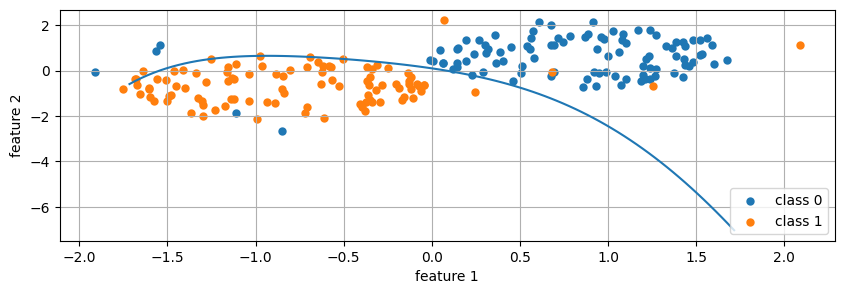

In [26]:
# Разделяющая линия.
div_line_x = np.linspace(-5, 5, num_dots)
div_line_x = normalize(div_line_x).reshape(-1,)

div_line_y = np.array([model.weights[deg - 1] * div_line_x ** deg for deg in range(1, degree + 1)]).transpose()
div_line_y = -(np.sum(div_line_y, axis=1) + model.bias) / model.weights[degree]

# Нормализация кластеров.
feature_1_norm = normalize(feature_1).reshape(-1,)
feature_2_norm = normalize(feature_2).reshape(-1,)

plt.figure(figsize=(10, 3))
plt.scatter(feature_1_norm[:num_dots], feature_2_norm[:num_dots], linewidths=0.01)
plt.scatter(feature_1_norm[num_dots:], feature_2_norm[num_dots:], linewidths=0.01)
plt.plot(div_line_x, div_line_y)
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.legend(["class 0", "class 1"], loc="lower right")
plt.grid(True)
plt.show()

In [27]:
test_prediction = model.predict(X_test_deg)
test_accuracy = np.sum((test_prediction > 0.5) == y_test) / len(test_prediction)
print(f"Test accuracy: {round(test_accuracy, 3)}")

Test accuracy: 0.882


In [28]:
train_prediction = model.predict(X_train_deg)
train_accuracy = np.sum((train_prediction > 0.5) == y_train) / len(train_prediction)
print(f"Train accuracy: {round(train_accuracy, 3)}")

Train accuracy: 0.917
